## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_5.csv')

## Rozdelenie dát

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## TextVectorization

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 lstm (LSTM)                 (None, 6000, 256)         525312    
                                                                 
 dropout (Dropout)           (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 6000, 128)         148224    
                                                             

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
159/159 [==============================] - 99s 555ms/step - loss: 4.3665 - accuracy: 0.0458 - val_loss: 3.8616 - val_accuracy: 0.1773
Epoch 2/15
159/159 [==============================] - 82s 518ms/step - loss: 3.8399 - accuracy: 0.1160 - val_loss: 3.2357 - val_accuracy: 0.2270
Epoch 3/15
159/159 [==============================] - 81s 507ms/step - loss: 3.6939 - accuracy: 0.1452 - val_loss: 3.1274 - val_accuracy: 0.2908
Epoch 4/15
159/159 [==============================] - 77s 484ms/step - loss: 3.7325 - accuracy: 0.1460 - val_loss: 3.5730 - val_accuracy: 0.1702
Epoch 5/15
159/159 [==============================] - 74s 462ms/step - loss: 3.6404 - accuracy: 0.1500 - val_loss: 3.1827 - val_accuracy: 0.2624
Epoch 6/15
159/159 [==============================] - 76s 478ms/step - loss: 3.6886 - accuracy: 0.1650 - val_loss: 3.2255 - val_accuracy: 0.2908
Epoch 7/15
159/159 [==============================] - 75s 471ms/step - loss: 3.6285 - accuracy: 0.1800 - val_loss: 3.1850 - val_ac

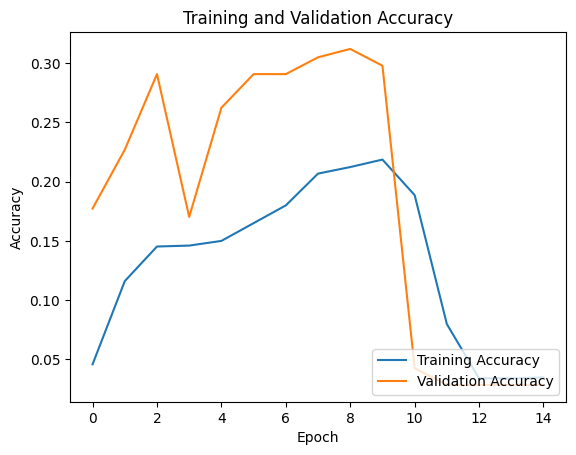

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 4s 253ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.048295454545454544
F1 Score: 0.004449987681694998
Precision: 0.0023324509297520664
Recall: 0.048295454545454544


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         394240    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=15, batch_size=8)

Epoch 1/15
159/159 [==============================] - 79s 472ms/step - loss: 4.0098 - accuracy: 0.0845 - val_loss: 3.3191 - val_accuracy: 0.1418
Epoch 2/15
159/159 [==============================] - 74s 463ms/step - loss: 3.4622 - accuracy: 0.1294 - val_loss: 2.9867 - val_accuracy: 0.2766
Epoch 3/15
159/159 [==============================] - 71s 449ms/step - loss: 3.0023 - accuracy: 0.2328 - val_loss: 2.7392 - val_accuracy: 0.3121
Epoch 4/15
159/159 [==============================] - 72s 455ms/step - loss: 2.6546 - accuracy: 0.2881 - val_loss: 2.7077 - val_accuracy: 0.3404
Epoch 5/15
159/159 [==============================] - 70s 443ms/step - loss: 2.4068 - accuracy: 0.3315 - val_loss: 2.4959 - val_accuracy: 0.3830
Epoch 6/15
159/159 [==============================] - 73s 459ms/step - loss: 2.1553 - accuracy: 0.3812 - val_loss: 2.2654 - val_accuracy: 0.4255
Epoch 7/15
159/159 [==============================] - 72s 454ms/step - loss: 1.9172 - accuracy: 0.4309 - val_loss: 2.1292 - val_ac

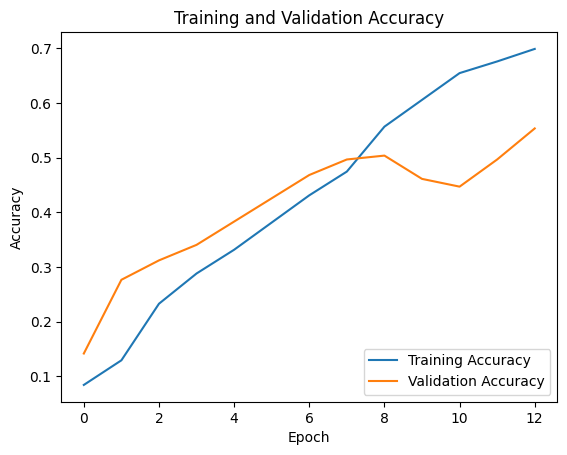

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 3s 202ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.5113636363636364
F1 Score: 0.5165440041062669
Precision: 0.574891502634962
Recall: 0.5113636363636364


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(128, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(64)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_3 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 lstm_3 (LSTM)               (None, 6000, 128)         197120    
                                                                 
 dropout_8 (Dropout)         (None, 6000, 128)         0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
108/108 [==============================] - 55s 463ms/step - loss: 2.9313 - accuracy: 0.0708 - val_loss: 2.8302 - val_accuracy: 0.0729
Epoch 2/10
108/108 [==============================] - 47s 437ms/step - loss: 2.7940 - accuracy: 0.0708 - val_loss: 2.8316 - val_accuracy: 0.0833
Epoch 3/10
108/108 [==============================] - 48s 445ms/step - loss: 2.6544 - accuracy: 0.1137 - val_loss: 2.8215 - val_accuracy: 0.0833
Epoch 4/10
108/108 [==============================] - 47s 433ms/step - loss: 2.4489 - accuracy: 0.2042 - val_loss: 2.7697 - val_accuracy: 0.1354
Epoch 5/10
108/108 [==============================] - 47s 439ms/step - loss: 2.0476 - accuracy: 0.3399 - val_loss: 2.9319 - val_accuracy: 0.1146
Epoch 6/10
108/108 [==============================] - 45s 415ms/step - loss: 1.7692 - accuracy: 0.4200 - val_loss: 3.3105 - val_accuracy: 0.1146
Epoch 7/10
108/108 [==============================] - 47s 437ms/step - loss: 1.6269 - accuracy: 0.4652 - val_loss: 3.3641 - val_ac

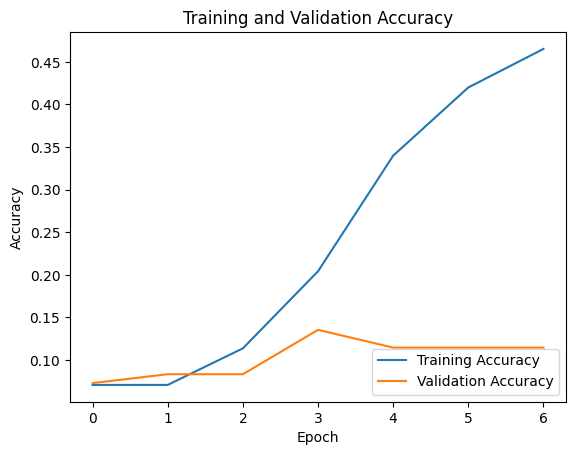

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 2s 175ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.10833333333333334
F1 Score: 0.09425630665624506
Precision: 0.13210502869748803
Recall: 0.10833333333333334
